# Notebook 2 — Data Quality and Exploratory Data Analysis (EDA)

Purpose:
- Standardize column names and create a canonical cleaned CSV that every later notebook will read.
- Inspect per-region counts, missingness, distributions, seasonality and autocorrelation.
- Save model_ready_dataset_clean.csv into 4_data_analysis/model_datasets/ for downstream notebooks.

Notes:
- Paths are relative; run this notebook from the repository root or adjust paths accordingly.
- This notebook does not train models; it focuses on data correctness and actionable diagnostics.

In [2]:
# Imports and paths
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import STL

sns.set(style='whitegrid')

model_ready_path = os.path.join('4_data_analysis','model_datasets','model_ready_dataset.csv')
final_merged_path = os.path.join('1_datasets','Final_dataset','final_merged_dataset.csv')
cleaned_out_path = os.path.join('..','4_data_analysis','model_datasets','model_ready_dataset_clean.csv')
os.makedirs(os.path.dirname(cleaned_out_path), exist_ok=True)

print('Looking for data files:')
print(' - model_ready:', model_ready_path)
print(' - final_merged:', final_merged_path)


Looking for data files:
 - model_ready: 4_data_analysis\model_datasets\model_ready_dataset.csv
 - final_merged: 1_datasets\Final_dataset\final_merged_dataset.csv


In [ ]:
# Helper: convert wide final merged dataset to monthly long format (same logic as Notebook 0)
def create_monthly_from_annual(df_wide):
    months = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    rain_long = df_wide.melt(id_vars=["REGION","YEAR"],
                            value_vars=[m + "_RAIN" for m in months],
                            var_name="Month_Rain", value_name="Rainfall")
    temp_long = df_wide.melt(id_vars=["REGION","YEAR"],
                            value_vars=[m + "_TEMP" for m in months],
                            var_name="Month_Temp", value_name="Temperature")
    rain_long["Month"] = rain_long["Month_Rain"].str.split("_").str[0]
    temp_long["Month"] = temp_long["Month_Temp"].str.split("_").str[0]
    df_long = pd.merge(
        rain_long[["REGION","YEAR","Month","Rainfall"]],
        temp_long[["REGION","YEAR","Month","Temperature"]],
        on=["REGION","YEAR","Month"]
    )
    month_order = {"JAN":1,"FEB":2,"MAR":3,"APR":4,"MAY":5,"JUN":6,
                "JUL":7,"AUG":8,"SEP":9,"OCT":10,"NOV":11,"DEC":12}
    df_long["Month_Num"] = df_long["Month"].map(month_order)
    df_long = df_long.sort_values(["REGION","YEAR","Month_Num"]).reset_index(drop=True)
    df_long["Time"] = df_long.groupby("REGION").cumcount()
    return df_long

# Function to canonicalize lag column names (if short names exist)
def standardize_lag_names(df):
    rename_map = {
        'Rain_lag_1': 'Rainfall_lag_1', 'Rain_lag_2': 'Rainfall_lag_2', 'Rain_lag_3': 'Rainfall_lag_3', 'Rain_lag_12': 'Rainfall_lag_12',
        'Temp_lag_1': 'Temperature_lag_1', 'Temp_lag_2': 'Temperature_lag_2', 'Temp_lag_3': 'Temperature_lag_3', 'Temp_lag_12': 'Temperature_lag_12',
        # also allow old names that notebooks may have created
        'Rain_lag1': 'Rainfall_lag_1', 'Temp_lag1': 'Temperature_lag_1'
    }
    present_map = {k:v for k,v in rename_map.items() if k in df.columns}
    if present_map:
        df = df.rename(columns=present_map)
    # If both short and canonical exist, drop short duplicates
    for short, canon in rename_map.items():
        if short in df.columns and canon in df.columns:
            df = df.drop(columns=[short])
    return df

def ensure_year_month(df):
    # Normalize YEAR column
    if 'Year' in df.columns and 'YEAR' not in df.columns:
        df = df.rename(columns={'Year': 'YEAR'})
    if 'MONTH' in df.columns and 'Month' not in df.columns:
        df = df.rename(columns={'MONTH': 'Month'})
    # Month_Num mapping
    if 'Month_Num' not in df.columns:
        if 'Month' in df.columns and df['Month'].dtype == object:
            month_map = {"JAN":1,"FEB":2,"MAR":3,"APR":4,"MAY":5,"JUN":6,
                        "JUL":7,"AUG":8,"SEP":9,"OCT":10,"NOV":11,"DEC":12}
            df['Month_Num'] = df['Month'].map(month_map)
        elif 'Month' in df.columns:
            df['Month_Num'] = df['Month']
        else:
            raise KeyError('No Month or Month_Num column found.')
    # Ensure YEAR exists
    if 'YEAR' not in df.columns and 'year' in df.columns:
        df = df.rename(columns={'year': 'YEAR'})
    return df


In [ ]:
# Replacement cell: robust dataset loader with helpful diagnostics
import os
import glob
from pprint import pprint

# Print working dir for debugging
print("Current working directory:", os.getcwd())

# Candidate file names we expect
candidates = [
    os.path.join("4_data_analysis","model_datasets","model_ready_dataset_clean.csv"),
    os.path.join("4_data_analysis","model_datasets","model_ready_dataset.csv"),
    os.path.join("4_data_analysis","model_datasets","model_ready_dataset_clean.csv"),
    os.path.join("4_data_analysis","model_datasets","model_ready_dataset.csv"),
    os.path.join("1_datasets","Final_dataset","final_merged_dataset.csv"),
    os.path.join("..","1_datasets","Final_dataset","final_merged_dataset.csv"),
    "final_merged_dataset.csv",
]

# Try the explicit candidate paths first
found = None
for p in candidates:
    if os.path.exists(p):
        found = p
        break

# If nothing found in candidate list, do a recursive search for likely files
if not found:
    print("No candidate path existed. Searching repo for likely filenames (this may take a moment)...")
    # search for exact filenames
    matches = glob.glob("**/model_ready_dataset*.csv", recursive=True) + glob.glob("**/final_merged_dataset.csv", recursive=True)
    # unique and filter out hidden dirs
    matches = sorted(set(matches))
    if matches:
        print("Found the following candidates in the repo:")
        pprint(matches)
        # pick the preferred one if possible
        pref_order = [
            "model_ready_dataset_clean.csv",
            "model_ready_dataset.csv",
            "final_merged_dataset.csv"
        ]
        for pref in pref_order:
            for m in matches:
                if m.endswith(pref):
                    found = m
                    break
            if found:
                break
    else:
        print("No matching files found with recursive search.")
        # show directory listing for the two expected parent dirs to help debug
        for check in ["4_data_analysis/model_datasets", "1_datasets/Final_dataset", "1_datasets"]:
            if os.path.exists(check):
                print(f"\nContents of {check}:")
                try:
                    pprint(sorted(os.listdir(check)))
                except Exception:
                    print("  (could not list)")
            else:
                print(f"\n{check} not found in current working directory tree.")

if not found:
    # Nothing found — give actionable instructions
    raise FileNotFoundError(
        "No input dataset found. Please do one of the following:\n"
        "1) Place final_merged_dataset.csv at 1_datasets/Final_dataset/final_merged_dataset.csv (relative to repo root), OR\n"
        "2) Place a model-ready CSV at 4_data_analysis/model_datasets/model_ready_dataset.csv (or _clean.csv), OR\n"
        "3) Upload the correct CSV into the notebook working directory.\n\n"
        "If you're running the notebook from within '4_data_analysis' directory, try using '../1_datasets/Final_dataset/final_merged_dataset.csv'.\n"
        "Use the search output above to see where files are located."
    )

print("Loading dataset from:", found)

# Load:
df = pd.read_csv(found)

# If this is the wide final_merged file (has JAN_RAIN columns), detect and convert to monthly long
wide_like = any(c.endswith("_RAIN") or c.endswith("_TEMP") for c in df.columns)
if wide_like and 'Month' not in df.columns:
    print("Detected wide-format dataset. Converting to monthly long format...")
    months = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    # Melt rainfall
    rain_long = df.melt(id_vars=["REGION","YEAR"], value_vars=[m + "_RAIN" for m in months],
                        var_name="Month_Rain", value_name="Rainfall")
    temp_long = df.melt(id_vars=["REGION","YEAR"], value_vars=[m + "_TEMP" for m in months],
                        var_name="Month_Temp", value_name="Temperature")
    rain_long["Month"] = rain_long["Month_Rain"].str.split("_").str[0]
    temp_long["Month"] = temp_long["Month_Temp"].str.split("_").str[0]
    df = pd.merge(rain_long[["REGION","YEAR","Month","Rainfall"]],
                temp_long[["REGION","YEAR","Month","Temperature"]],
                on=["REGION","YEAR","Month"])
    month_order = {"JAN":1,"FEB":2,"MAR":3,"APR":4,"MAY":5,"JUN":6,"JUL":7,"AUG":8,"SEP":9,"OCT":10,"NOV":11,"DEC":12}
    df["Month_Num"] = df["Month"].map(month_order)
    df = df.sort_values(["REGION","YEAR","Month_Num"]).reset_index(drop=True)
    df["Time"] = df.groupby("REGION").cumcount()
    print("Converted to long. Shape:", df.shape)
else:
    print("Loaded dataset appears already long-format or model-ready. Shape:", df.shape)

# Quick sanity output
print("\nColumns:", df.columns.tolist())
print("\nHead:")
display(df.head())

# Save a canonical copy in model_datasets for downstream notebooks (if possible)
out_dir = os.path.join("..","4_data_analysis","model_datasets")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "model_ready_dataset_clean.csv")
try:
    df.to_csv(out_path, index=False)
    print("\nSaved canonical copy to:", out_path)
except Exception as e:
    print("\nCould not save canonical copy to", out_path, ":", e)

# The variable 'df' is now loaded/converted and ready for the rest of the notebook.

Current working directory: c:\Codes\MIT-ELO2-\4_data_analysis
Loading dataset from: 4_data_analysis\model_datasets\model_ready_dataset_clean.csv
Loaded dataset appears already long-format or model-ready. Shape: (2100, 15)

Columns: ['REGION', 'YEAR', 'Month', 'Rainfall', 'Temperature', 'Month_Num', 'Time', 'Rainfall_lag_1', 'Rainfall_lag_2', 'Rainfall_lag_3', 'Rainfall_lag_12', 'Temperature_lag_1', 'Temperature_lag_2', 'Temperature_lag_3', 'Temperature_lag_12']

Head:


,REGION,YEAR,Month,Rainfall,Temperature,Month_Num,Time,Rainfall_lag_1,Rainfall_lag_2,Rainfall_lag_3,Rainfall_lag_12,Temperature_lag_1,Temperature_lag_2,Temperature_lag_3,Temperature_lag_12
0,Central,1990,JAN,0.000,23.057667,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Central,1990,FEB,0.000,22.018000,2,1,0.0,NaN,NaN,NaN,23.057667,NaN,NaN,NaN
2,Central,1990,MAR,0.000,25.144778,3,2,0.0,0.0,NaN,NaN,22.018000,23.057667,NaN,NaN
3,Central,1990,APR,0.000,30.844667,4,3,0.0,0.0,0.0,NaN,25.144778,22.018000,23.057667,NaN
4,Central,1990,MAY,0.002,33.960222,5,4,0.0,0.0,0.0,NaN,30.844667,25.144778,22.018000,NaN



Saved canonical copy to: ..\4_data_analysis\model_datasets\model_ready_dataset_clean.csv


In [ ]:
# Missingness and how many rows would be lost by standard lag/rolling requirements
canonical_lag_cols = [f'Rainfall_lag_{i}' for i in [1,2,3,12]] + [f'Temperature_lag_{i}' for i in [1,2,3,12]]
existing_lags = [c for c in canonical_lag_cols if c in df.columns]
print('Canonical lag columns expected:', canonical_lag_cols)
print('Existing lag columns found:', existing_lags)

# If lag columns are missing, compute the standard lags here (non-destructive)
to_create = [c for c in canonical_lag_cols if c not in df.columns]
if to_create:
    print('Creating missing lag columns:', to_create)
    for cname in to_create:
        if cname.startswith('Rainfall'):
            base = 'Rainfall'
        else:
            base = 'Temperature'
        lagn = int(cname.split('_')[-1])
        df[cname] = df.groupby('REGION')[base].shift(lagn)

print('\nAfter ensuring lags, null counts for lag columns:')
print(df[[c for c in canonical_lag_cols if c in df.columns]].isna().sum())

# If you also plan to use rolling features, show how many rows will remain if we require all lags
rows_if_require_lags = df.dropna(subset=[c for c in canonical_lag_cols if c in df.columns]).shape[0]
print(f'Rows after dropping rows missing ANY canonical lags: {rows_if_require_lags} (current {df.shape[0]})')

# Save the cleaned but un-rolled dataset for now
df.to_csv(cleaned_out_path, index=False)
print('Saved canonical cleaned dataset to', cleaned_out_path)


Canonical lag columns expected: ['Rainfall_lag_1', 'Rainfall_lag_2', 'Rainfall_lag_3', 'Rainfall_lag_12', 'Temperature_lag_1', 'Temperature_lag_2', 'Temperature_lag_3', 'Temperature_lag_12']
Existing lag columns found: ['Rainfall_lag_1', 'Rainfall_lag_2', 'Rainfall_lag_3', 'Rainfall_lag_12', 'Temperature_lag_1', 'Temperature_lag_2', 'Temperature_lag_3', 'Temperature_lag_12']

After ensuring lags, null counts for lag columns:
Rainfall_lag_1         5
Rainfall_lag_2        10
Rainfall_lag_3        15
Rainfall_lag_12       60
Temperature_lag_1      5
Temperature_lag_2     10
Temperature_lag_3     15
Temperature_lag_12    60
dtype: int64
Rows after dropping rows missing ANY canonical lags: 2040 (current 2100)
Saved canonical cleaned dataset to ..\4_data_analysis\model_datasets\model_ready_dataset_clean.csv


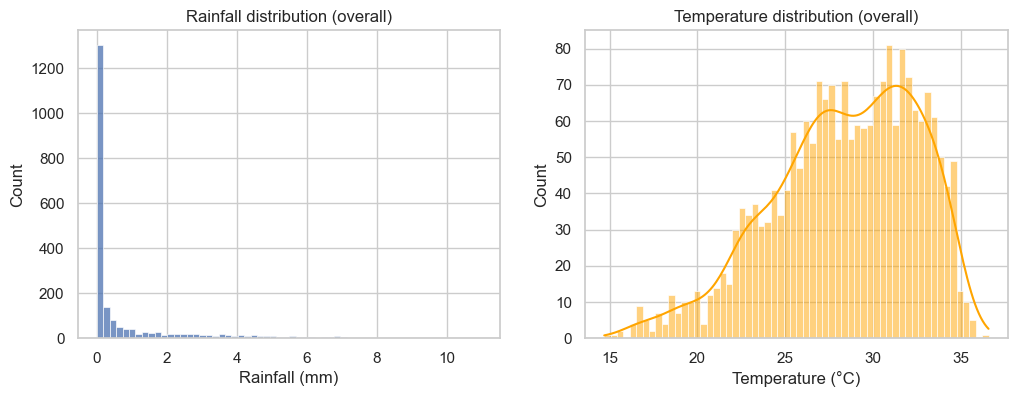

Rainfall skewness (raw): 2.463570497894507
Temperature skewness: -0.5543286609386592
Rainfall skew after log1p: 1.547086422283631


In [ ]:
# Quick distribution checks: Rainfall and Temperature overall
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['Rainfall'].dropna(), bins=60, kde=False)
plt.title('Rainfall distribution (overall)')
plt.xlabel('Rainfall (mm)')

plt.subplot(1,2,2)
sns.histplot(df['Temperature'].dropna(), bins=60, kde=True, color='orange')
plt.title('Temperature distribution (overall)')
plt.xlabel('Temperature (°C)')
plt.show()

print('Rainfall skewness (raw):', skew(df['Rainfall'].dropna()))
print('Temperature skewness:', skew(df['Temperature'].dropna()))

# Try log1p for rainfall and show skewness improvement
rain_log_skew = skew(np.log1p(df['Rainfall'].fillna(0)))
print('Rainfall skew after log1p:', rain_log_skew)


In [ ]:
# Robust per-region summary aggregation

# Ensure df exists
try:
    df
except NameError:
    raise NameError("DataFrame 'df' is not defined. Make sure the dataset has been loaded into variable df earlier in the notebook.")

# Required columns check
required_cols = ['REGION', 'Rainfall', 'Temperature']
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns for aggregation: {missing_cols}. Check earlier loading/standardization steps.")

# Compute per-region aggregation using named-aggregation tuples
per_region = df.groupby('REGION').agg(
    rows=('REGION', 'size'),
    rain_mean=('Rainfall', 'mean'),
    rain_median=('Rainfall', 'median'),
    # fraction of months with rainfall > 0
    rain_nonzero_pct=('Rainfall', lambda x: (x > 0).mean()),
    temp_mean=('Temperature', 'mean'),
    temp_std=('Temperature', 'std')
).sort_values('rows', ascending=False)

# Nicely display results
pd.set_option('display.float_format', lambda v: f"{v:.4f}")
print("Per-region summary (top rows):")
display(per_region.head(50))   # show up to 50 regions if present

# Optionally save the summary (uncomment and adjust path if you want)
# out_dir = os.path.join('..','4_data_analysis','model_datasets')
# os.makedirs(out_dir, exist_ok=True)
# per_region.to_csv(os.path.join(out_dir, 'per_region_summary.csv'))

Per-region summary (top rows):


,rows,rain_mean,rain_median,rain_nonzero_pct,temp_mean,temp_std
REGION,,,,,,
Central,420,0.5406,0.0483,0.6690,29.2012,3.8626
East,420,0.3226,0.0734,0.8548,29.2378,3.7734
North,420,0.0440,0.0004,0.5286,27.3632,6.1163
South,420,2.1318,1.0197,0.9024,28.5208,2.3836
West,420,1.1647,0.1390,0.6976,27.5790,3.2684


ACF/seasonality example for region: Central


C:\Users\amhx1\AppData\Local\Temp\ipykernel_2304\663966187.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_series = g['Temperature'].fillna(method='ffill').values


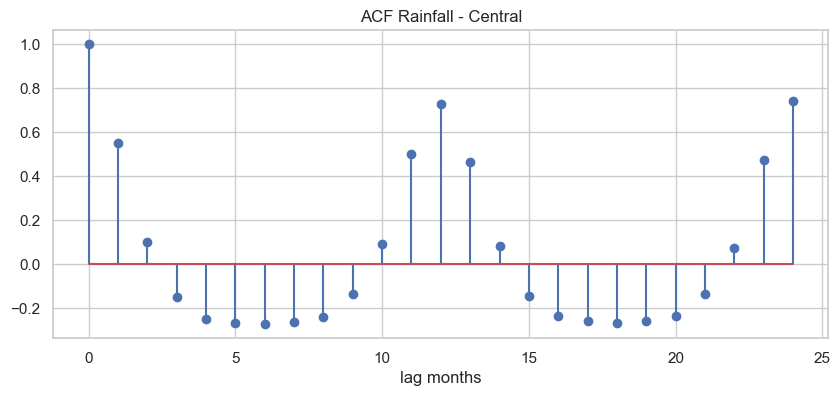

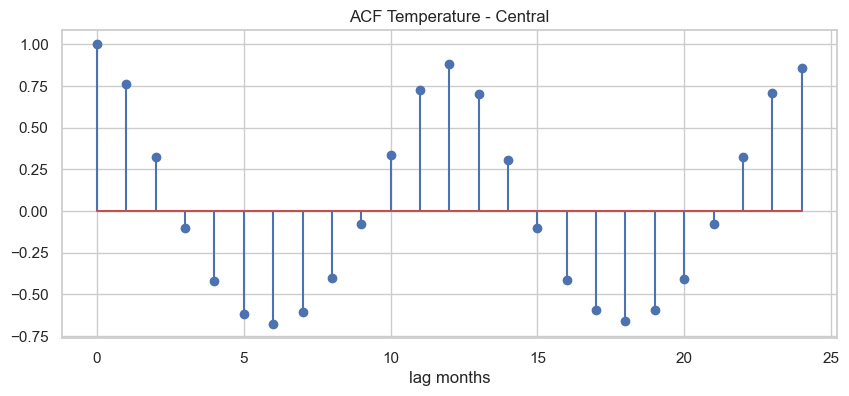

In [ ]:
# ACF example for Rainfall and Temperature for a sample region
sample_region = df['REGION'].unique()[0]
print('ACF/seasonality example for region:', sample_region)
g = df[df['REGION']==sample_region].sort_values(['YEAR','Month_Num'])

max_lag = 36
rain_series = g['Rainfall'].fillna(0).values
temp_series = g['Temperature'].fillna(method='ffill').values

rain_acf = acf(rain_series, nlags=24, fft=True)
temp_acf = acf(temp_series, nlags=24, fft=True)

plt.figure(figsize=(10,4))
plt.stem(range(len(rain_acf)), rain_acf)
plt.title(f'ACF Rainfall - {sample_region}')
plt.xlabel('lag months')
plt.show()

plt.figure(figsize=(10,4))
plt.stem(range(len(temp_acf)), temp_acf)
plt.title(f'ACF Temperature - {sample_region}')
plt.xlabel('lag months')
plt.show()


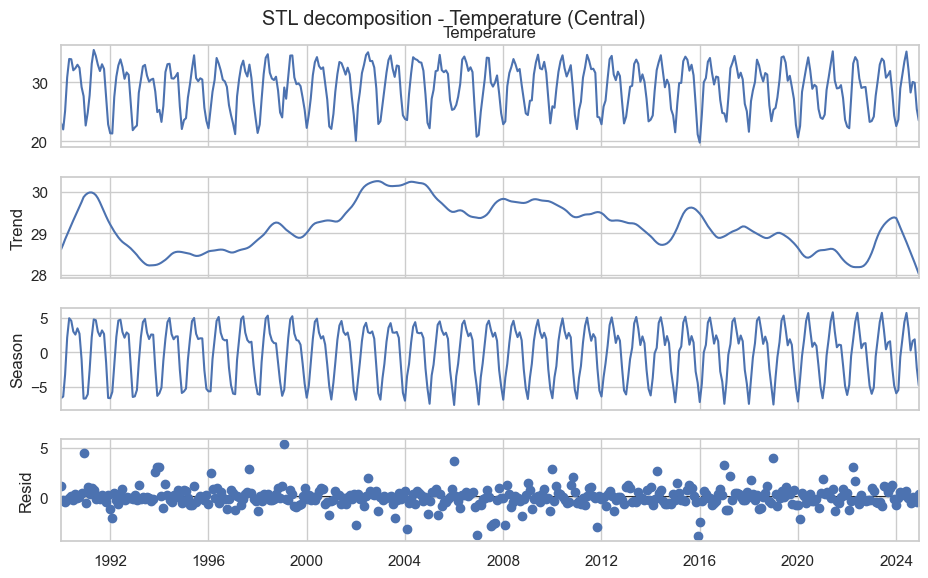

In [ ]:
# Seasonal decomposition (STL) demonstration for the sample region's temperature
try:
    g2 = g.copy()
    # Build a datetime index for decomposition
    g2['date'] = pd.to_datetime(dict(year=g2['YEAR'].astype(int), month=g2['Month_Num'].astype(int), day=1))
    g2 = g2.set_index('date')
    stl = STL(g2['Temperature'].astype(float), period=12, robust=True)
    res = stl.fit()
    fig = res.plot()
    fig.set_size_inches(10,6)
    plt.suptitle(f'STL decomposition - Temperature ({sample_region})')
    plt.show()
except Exception as e:
    print('Seasonal decomposition failed:', e)
    print('This may need statsmodels >= 0.12 and non-null Temperature values for the sample region.')


Actionable notes and recommended next steps:
- We standardized lag column names and YEAR/Month; a canonical cleaned CSV was saved to 4_data_analysis/model_datasets/model_ready_dataset_clean.csv. Use this file in later notebooks.
- Rainfall is highly skewed and zero-inflated. I recommend trying log1p(Rainfall) for regression or a two-stage model (classification wet/dry + regression for positive rainfall).
- Rolling features (e.g., 3-month and 12-month rolling means) will reduce usable rows due to min_periods; decide whether to allow partial-window values (min_periods<window) or accept fewer rows.
- Next notebook (Notebook 3) will create feature-engineering pipelines (lags, rolls, cyclical month features), explicitly log number of rows dropped and save a final model-ready CSV for modeling.
